The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called `camera_cal`.  The images in `test_images` are for testing your pipeline on single frames.  If you want to extract more test images from the videos, you can simply use an image writing method like `cv2.imwrite()`, i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.  

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called `output_images`, and include a description in your writeup for the project of what each image shows.    The video called `project_video.mp4` is the video your pipeline should work well on.  

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
%matplotlib inline

In [2]:
def plot_pics(images=[], title=[]):
    rows, columns = 1, len(images)
    fig, plot_array = plt.subplots(rows, columns, figsize=(20,10))
    
    for index, plot in enumerate(plot_array.ravel()):
        plot.imshow(images[index], cmap='gray')
        if len(title) == 0 or len(title) != len(images):
            plot.set_title(index)
        else:
            plot.set_title(title[index])
    
    plt.draw()
    
def plot_pics2(images=[], title=[]):
    rows, columns = 2, len(images)//2
    fig, plot_array = plt.subplots(rows, columns, figsize=(20,10))
    
    for index, plot in enumerate(plot_array.ravel()):
        if index < len(images):
            plot.imshow(images[index], cmap='gray')
            if len(title) == 0 or len(title) != len(images):
                plot.set_title(index)
            else:
                plot.set_title(title[index])
        else:
            plot.axis('off')
            
    
    plt.draw()

In [3]:
def binary_pic(binary_img):
    color_binary = np.dstack((binary_img, binary_img, binary_img)) * 255
    return color_binary

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images

In [4]:
from utils_calibration import corners_unwarp

In [5]:
objpoints = [] # 3D points in real world spcae
imgpoints = [] # 2D points in image plans

nx = 9 #  number of corners in any given row (x)
ny = 6 #  number of corners in a given column (y)

In [6]:
cal_images = glob.glob('./camera_cal/cali*.jpg')
for index, filename in enumerate(cal_images):
    warped_im, M = corners_unwarp(filename, nx, ny, objpoints, imgpoints)

None founded ./camera_cal\calibration01.jpg
./camera_cal\calibration02.jpg  complete
./camera_cal\calibration03.jpg  complete
None founded ./camera_cal\calibration04.jpg
None founded ./camera_cal\calibration05.jpg
./camera_cal\calibration06.jpg  complete
./camera_cal\calibration07.jpg  complete
./camera_cal\calibration08.jpg  complete
./camera_cal\calibration09.jpg  complete
./camera_cal\calibration10.jpg  complete
./camera_cal\calibration11.jpg  complete
./camera_cal\calibration12.jpg  complete
./camera_cal\calibration13.jpg  complete
./camera_cal\calibration14.jpg  complete
./camera_cal\calibration15.jpg  complete
./camera_cal\calibration16.jpg  complete
./camera_cal\calibration17.jpg  complete
./camera_cal\calibration18.jpg  complete
./camera_cal\calibration19.jpg  complete
./camera_cal\calibration20.jpg  complete


## Apply a distortion correction to raw images

In [7]:
from utils_calibration import cal_undistort

In [8]:
road_images = glob.glob('./test_images/*.jpg')
# undist_images = []
# for filename in road_images:
#     undist_im = cal_undistort(filename, objpoints, imgpoints)
# #     cv2.imwrite('./output_images/{}.jpg'.format(filename), undist_im)
#     undist_images.append(undist_im)

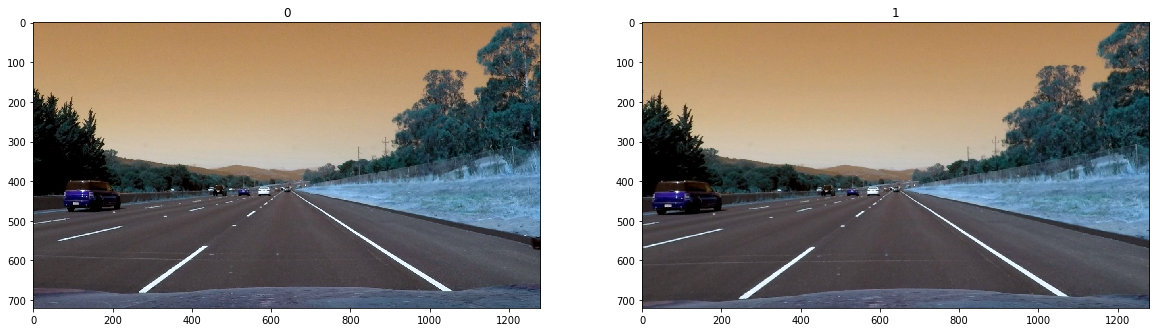

In [9]:
test_filename = road_images[1]; im0_test = cv2.imread(test_filename)
im1_undist = cal_undistort(im0_test, objpoints, imgpoints)
cv2.imwrite('./output_images/im0_test.jpg', im0_test)
cv2.imwrite('./output_images/im1_undist.jpg', im1_undist)
plot_pics([im0_test, im1_undist])

## Use color transforms, gradients, etc., to create a thresholded binary image

In [10]:
# # test code

# test_filename = road_images[7]; im0_test = cv2.imread(test_filename)
# im1_undist = cal_undistort(test_filename, objpoints, imgpoints)

# hls = cv2.cvtColor(im1_undist, cv2.COLOR_BGR2HLS)
# H = hls[:,:,0]; H_thresh = channel_thresh(H, 200, 255) #100
# L = hls[:,:,1]; L_thresh = channel_thresh(L, 210, 255)
# L_delete = channel_thresh(L, 0, 50)
# S = hls[:,:,2]; S_thresh = channel_thresh(S, 130, 255) #120

# S_combined_origin = np.zeros_like(H_thresh)
# S_combined_origin[(H_thresh == 0) & ((L_thresh == 1) | (S_thresh == 1))] = 1
# color_binary1 = np.dstack((np.zeros_like(H_thresh), S_combined_origin, L_delete)) * 255

# combined2 = np.zeros_like(H_thresh)
# combined2[((L_thresh == 1) | ((S_thresh == 1) & (L_delete == 0)))] = 1
# color_binary2 = np.dstack((np.zeros_like(H_thresh), combined2, H_thresh)) * 255

# S_combined = np.zeros_like(H_thresh)
# S_combined[(H_thresh == 0) & ((L_thresh == 1) | ((S_thresh == 1) & (L_delete == 0)))] = 1

# plot_pics2([im0_test, color_binary1, color_binary2, S_combined])

In [11]:
from utils_threshold import abs_sobel_thresh, mag_threshold, dir_threshold, channel_thresh, display_all_filters

In [12]:
def color_channel(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    L = hls[:,:,1]
    L_thresh = channel_thresh(L, 210, 255)
    L_delete = channel_thresh(L, 0, 50)
    S = hls[:,:,2]; S_thresh = channel_thresh(S, 130, 255) #120

    S_combined = np.zeros_like(L_thresh)
    S_combined[(L_thresh == 1) | ((S_thresh == 1) & (L_delete == 0))] = 1
    
    return S_combined

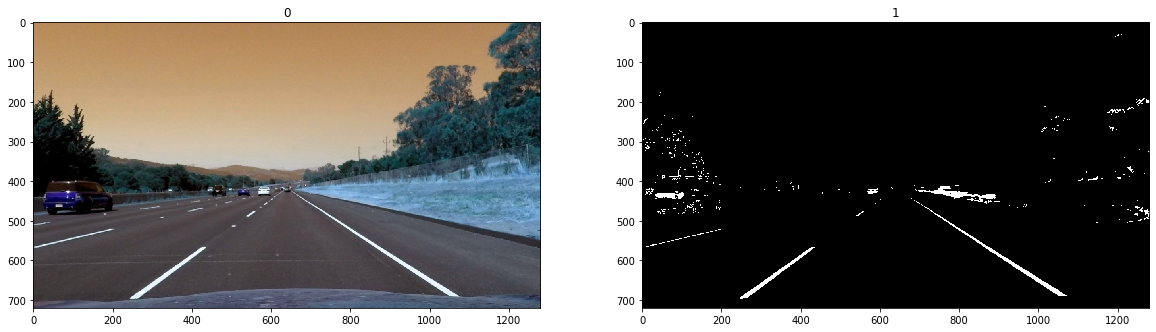

In [13]:
im2_colorChannel = color_channel(im1_undist)
cv2.imwrite('./output_images/im2_colorChannel.jpg', binary_pic(im2_colorChannel))
plot_pics([im1_undist, im2_colorChannel])

## Apply a perspective transform to rectify binary image ("birds-eye view").

In [14]:
# %matplotlib inline
# plt.imshow(im2_colorChannel, cmap='gray')
# plt.plot(200, 718, '.')
# plt.plot(530, 500, '.')
# plt.plot(769, 500, '.')
# plt.plot(1100, 718, '.')

In [15]:
from utils_transform import perspec_trans, inverse_trans

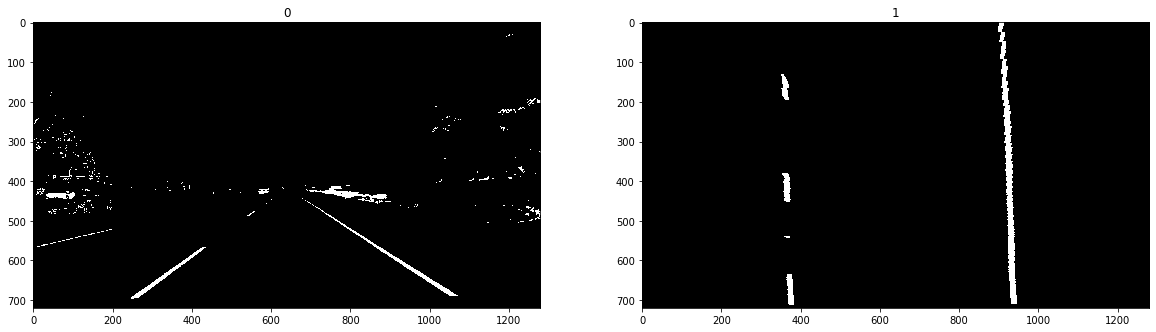

In [16]:
im3_perspecTrans = perspec_trans(im2_colorChannel)
cv2.imwrite('./output_images/im3_perspecTrans.jpg', binary_pic(im3_perspecTrans))
plot_pics([im2_colorChannel, im3_perspecTrans])

## Detect lane pixels and fit to find the lane boundary.

In [17]:
from utils_lane import measure_curvature_real, fit_polynomial, search_around_poly, calc_deviation

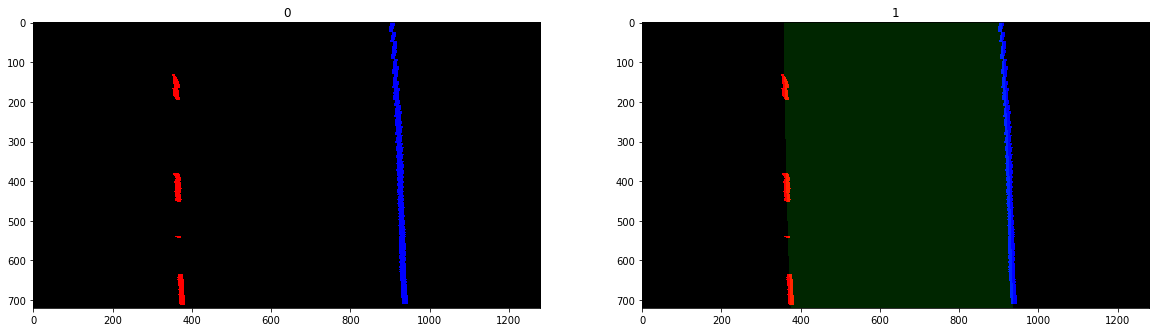

In [18]:
im4_firstfit, left_fit, right_fit = fit_polynomial(im3_perspecTrans)
im5_effi, ploty = search_around_poly(im3_perspecTrans, left_fit, right_fit)
cv2.imwrite('./output_images/im5_effi.jpg', im5_effi)
plot_pics([im4_firstfit, im5_effi])

## Determine the curvature of the lane and vehicle position with respect to center.

In [19]:
curvature = measure_curvature_real(ploty, im3_perspecTrans)
offset = calc_deviation(im3_perspecTrans, ploty, left_fit, right_fit)

## Warp the detected lane boundaries back onto the original image.
-  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

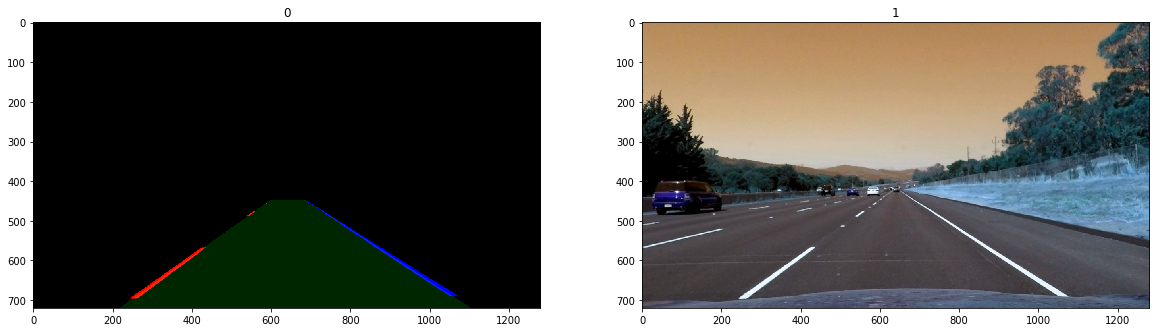

In [20]:
im6_inverse = inverse_trans(im5_effi)
plot_pics([im6_inverse, im1_undist])

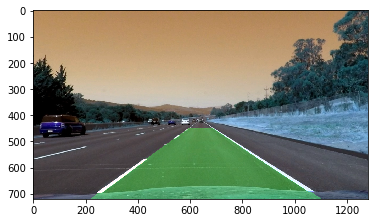

In [21]:
im7_final = cv2.addWeighted(im6_inverse, 2, im1_undist, 1, 0)
# result = cv2.addWeighted(result, 0.7, result, 0.7, 0)
cv2.imwrite('./output_images/im7_final.jpg', im7_final)
plt.imshow(im7_final)

True

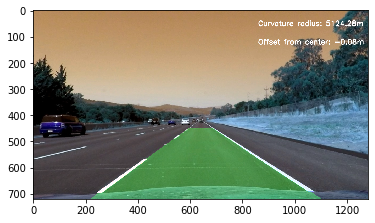

In [22]:
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(im7_final, 'Curvature radius: {:.02f}m'.format(curvature), (860, 60), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
cv2.putText(im7_final, 'Offset from center: {:.02f}m'.format(offset), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
plt.imshow(im7_final); cv2.imwrite('./output_images/im7_final.jpg', im7_final)